# Análisis Exploratorios de datos

Bibliotecas

In [28]:
# pandas for data loading, manipulation etc.
import pandas as pd


# numeric functions
import xgboost
import numpy as np
import collections
import math
import operator
from scipy import stats
from math import ceil
import time
import random as rnd
import statsmodels
import pandas_profiling
 
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline


# modelling
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet,Lars,LassoLars,SGDRegressor
from sklearn.linear_model import RidgeCV, LassoCV,BayesianRidge, LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,train_test_split
from sklearn.metrics import make_scorer,r2_score,mean_squared_error,roc_auc_score, accuracy_score,explained_variance_score
from sklearn.neighbors import KNeighborsRegressor #,KNearestNeighborsRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, minmax_scale
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE,SelectFromModel
from statsmodels.formula.api import poisson, negativebinomial,glm

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

# Carga de datos

In [2]:
# Load the data
datos = pd.read_csv('datacountstudents.csv')

Se estandarizan las variables continuas dependientes.
Se divide los 150 datos en test y training, se halla la media y la varianza del training y se transforma el test.

In [3]:
pd.read_csv('datacountstudents.csv').profile_report() 

Alta correlación entre las variable X1 con las X2, x11 y x17, la x2 xon la X11, la x31 con la x32, la x25 con la x26, x21 con x15 y x23, 

Se probaron las correlaciones con medidas no paramétricas y estas se siguen manteniendo

<IPython.core.display.Javascript object>


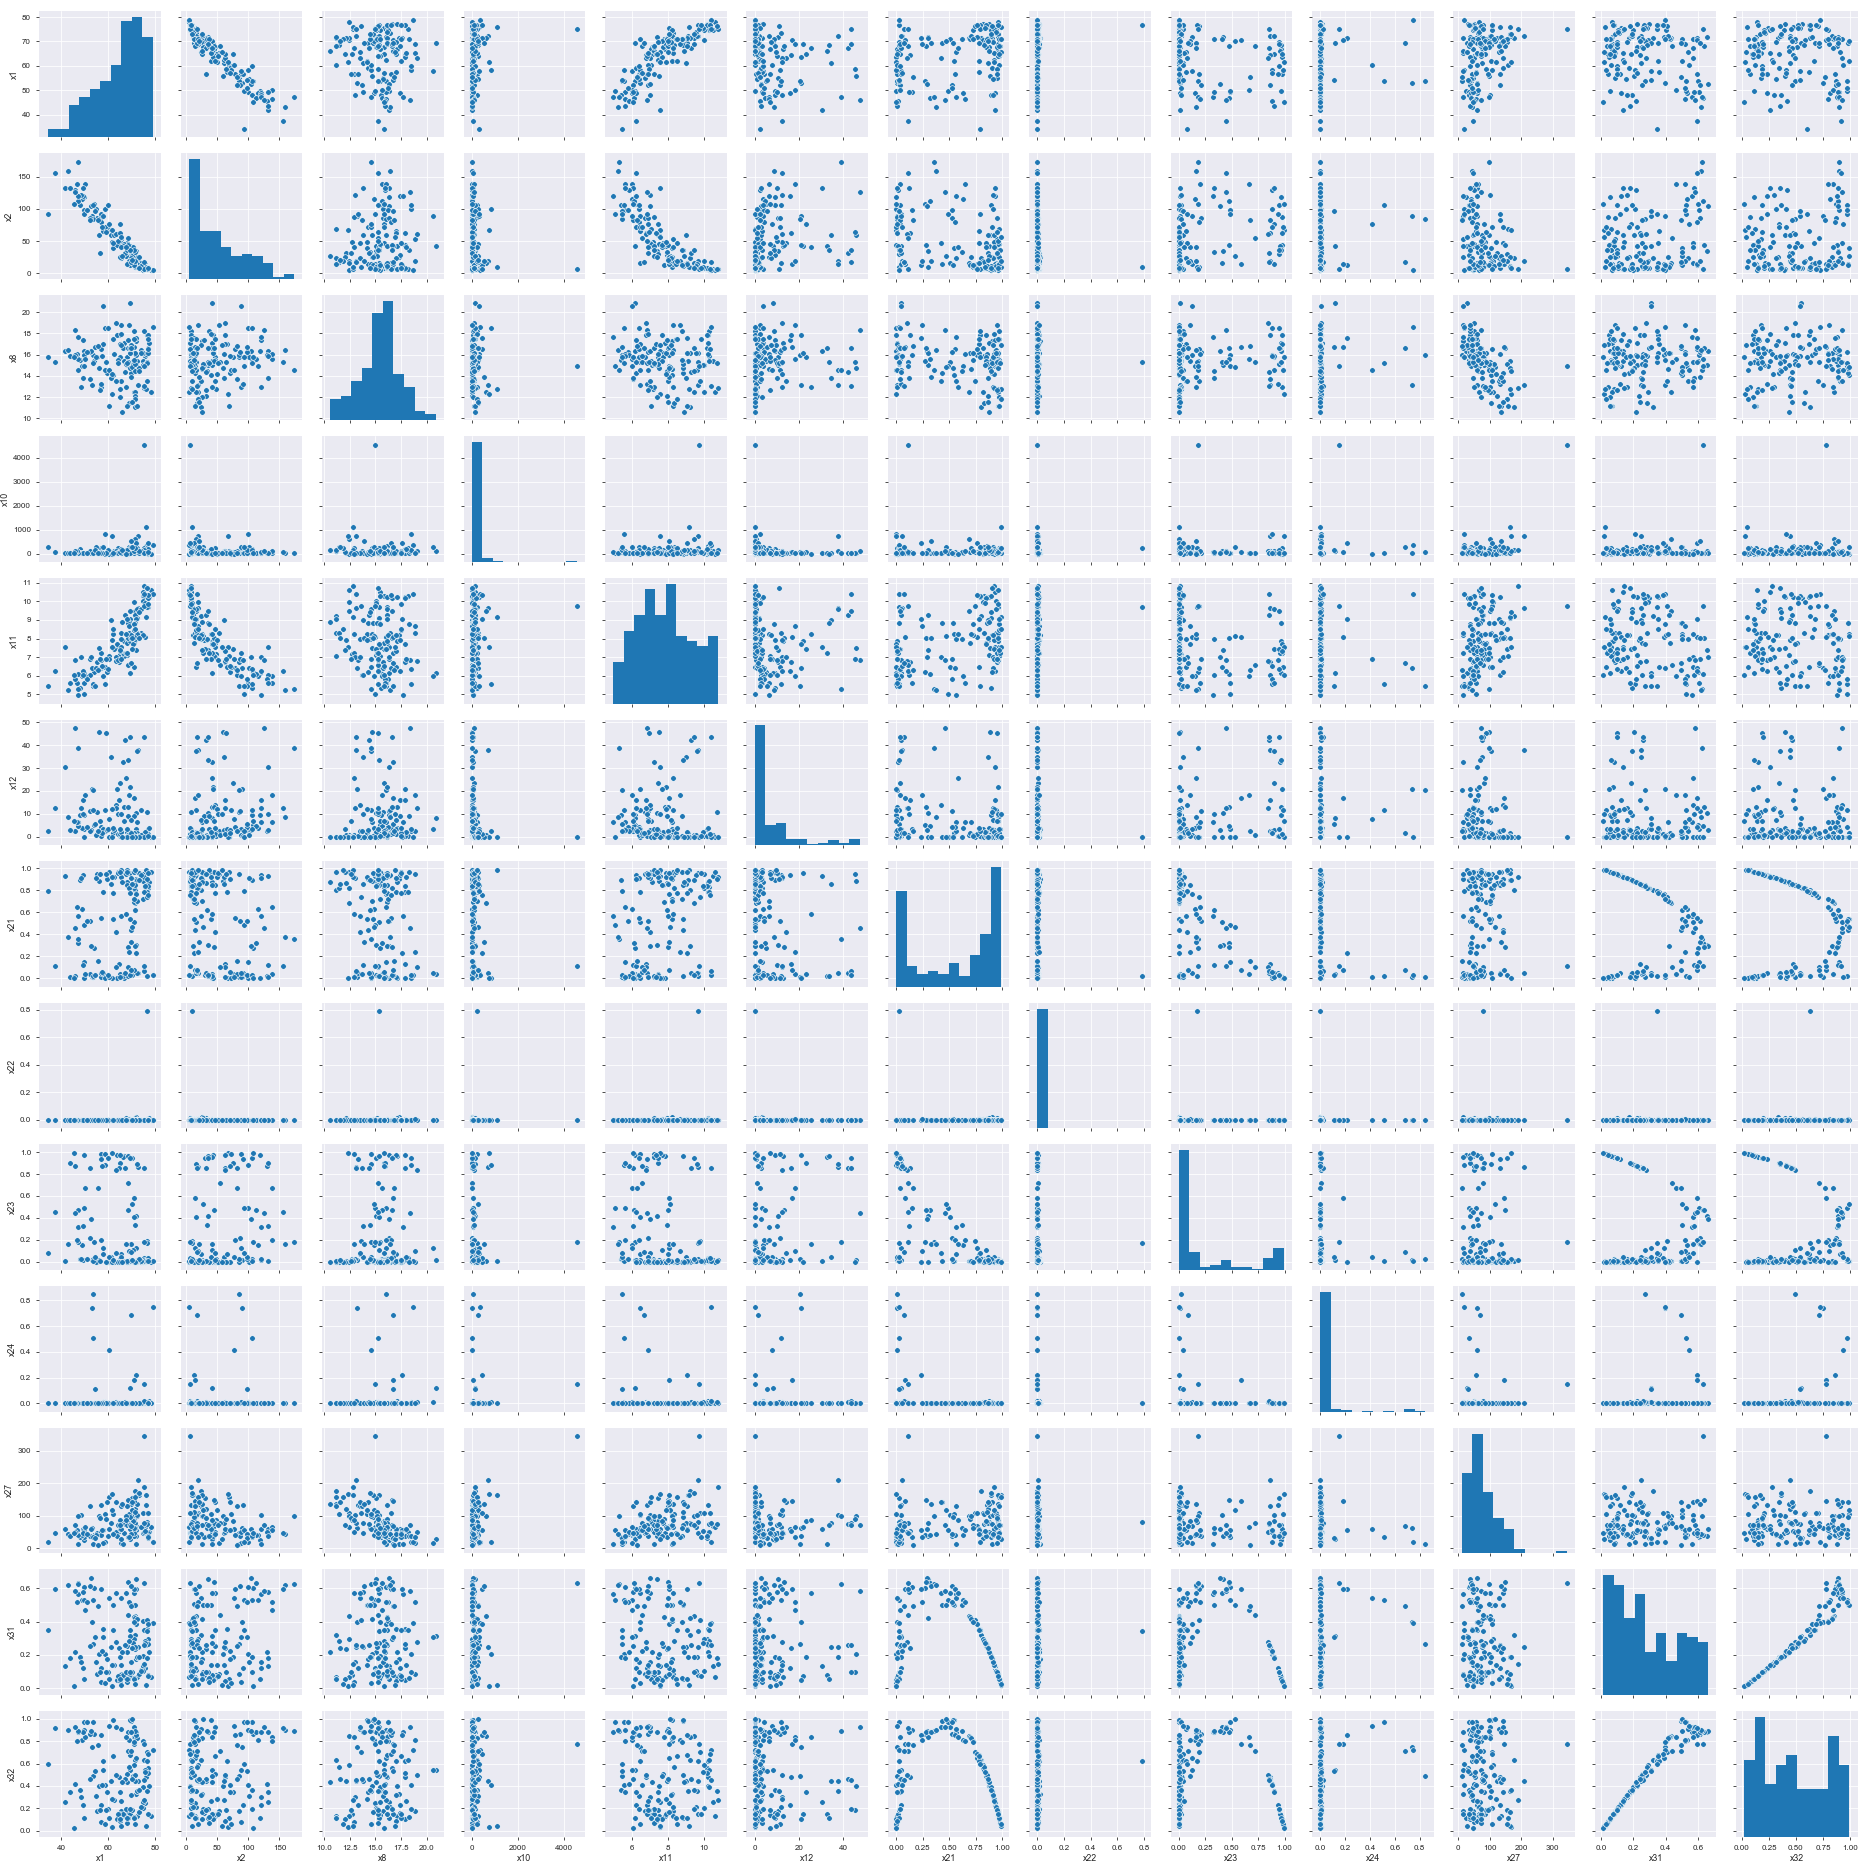

In [5]:
%matplotlib notebook
sns.pairplot(datos.loc[:,datos.dtypes == 'float64'])

In [5]:
Datos_con = datos.select_dtypes(exclude=['int64'])
Columns_C = Datos_con.columns[(Datos_con.dtypes.values == np.dtype('float64'))]
# Estandarizar solo continuas en train
col_names = Columns_C[0:13]
features_df = Datos_con[col_names]
scaler = StandardScaler().fit(features_df.values)
features_df = scaler.transform(features_df.values)
Datos_con[col_names] = features_df
#DATAFRAME CONTINUOS
Datos_con = pd.concat([Datos_con], axis=1, sort=False)
#Datos_con.head()

In [6]:
Datos_sc = datos.select_dtypes(exclude=['int64'])
# Estandarizar solo continuas en train
Datos_sc = datos.copy()
features_df = Datos_sc[col_names]
features_df = scaler.transform(features_df.values)
Datos_sc[col_names] = features_df
#DATAFRAME escalado
Datos_sc = pd.concat([Datos_sc], axis=1, sort=False)
Datos_sc = Datos_sc.iloc[:,1:]
# prepare for modeling
X = Datos_sc.drop(['yC'], axis=1)
y = Datos_sc['yC'].values
Datos_sc.head()

yC        x1        x2  x3  x4  x5  x6  x7        x8  x9    ...     \
0   1 -1.443483  1.662606   1   0   0   0   0  0.476844   0    ...      
1   0  0.750834 -0.378196   0   0   0   0   1 -0.207152  44    ...      
2   0  0.240590 -0.208129   0   1   0   0   0  0.866395  27    ...      
3   0 -2.258116  1.983304   0   0   1   0   0  0.473537   0    ...      
4   2  0.702415 -0.635726   1   0   0   0   0 -2.233465  31    ...      

        x23       x24  x25  x26       x27  x28  x29  x30       x31       x32  
0  2.092018 -0.240894    6    6 -1.124346    0    0    7 -1.173105 -1.267575  
1  0.516205 -0.243133    8    4 -0.845203    0    0    7  1.926569  1.326759  
2  2.075141 -0.243133    6    6 -0.629555    0    1    4 -1.114558 -1.196908  
3 -0.659147 -0.242387    6    4 -0.389961    0    0    7 -0.776095 -0.774072  
4 -0.670589 -0.243133    5    7  2.036944    0    0    3  0.183521  0.458084  

[5 rows x 33 columns]

<IPython.core.display.Javascript object>


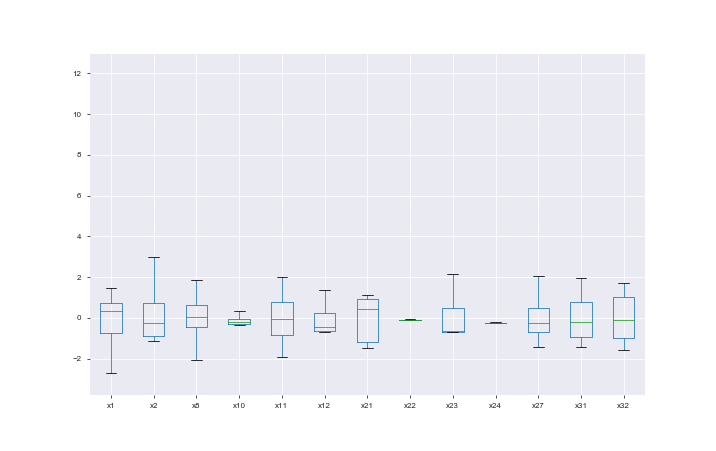

In [8]:
%matplotlib notebook
descriptive=Datos_con.describe()
Datos_con.plot(kind='box')

Se puede notar que gran cantidad de outliers en x10,x12, x24 y x27, sin embargo debido a la poca cantidad de datos y al no tener mayor información de estas variables se debe trabajar con estos datos.

<IPython.core.display.Javascript object>


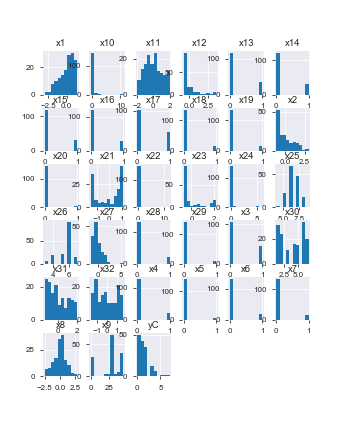

In [9]:
%matplotlib notebook
Datos_sc.hist()
plt.show()

<IPython.core.display.Javascript object>


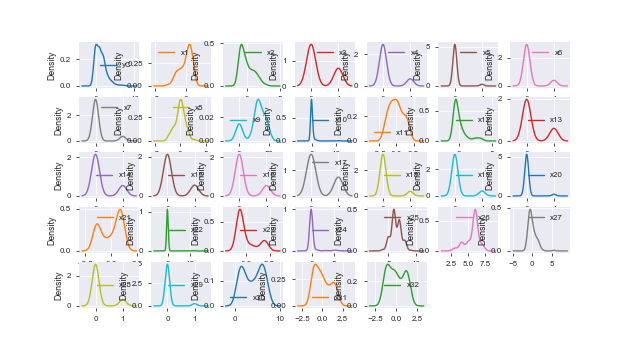

In [10]:
%matplotlib notebook
Datos_sc.plot(kind='density', subplots=True, layout=(5,7), sharex=False)
plt.show()

In [11]:
# extract names of numeric columns
dtypes = datos.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist() # object o 'category'

# choose any numeric column with less than 13 values to be
# "discrete". 13 chosen to include months of the year.
# other columns "continuous"
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = datos[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous and',
      len(cols_discrete),'are discrete.')


34 numeric columns, of which 15 are continuous and 19 are discrete.


<IPython.core.display.Javascript object>


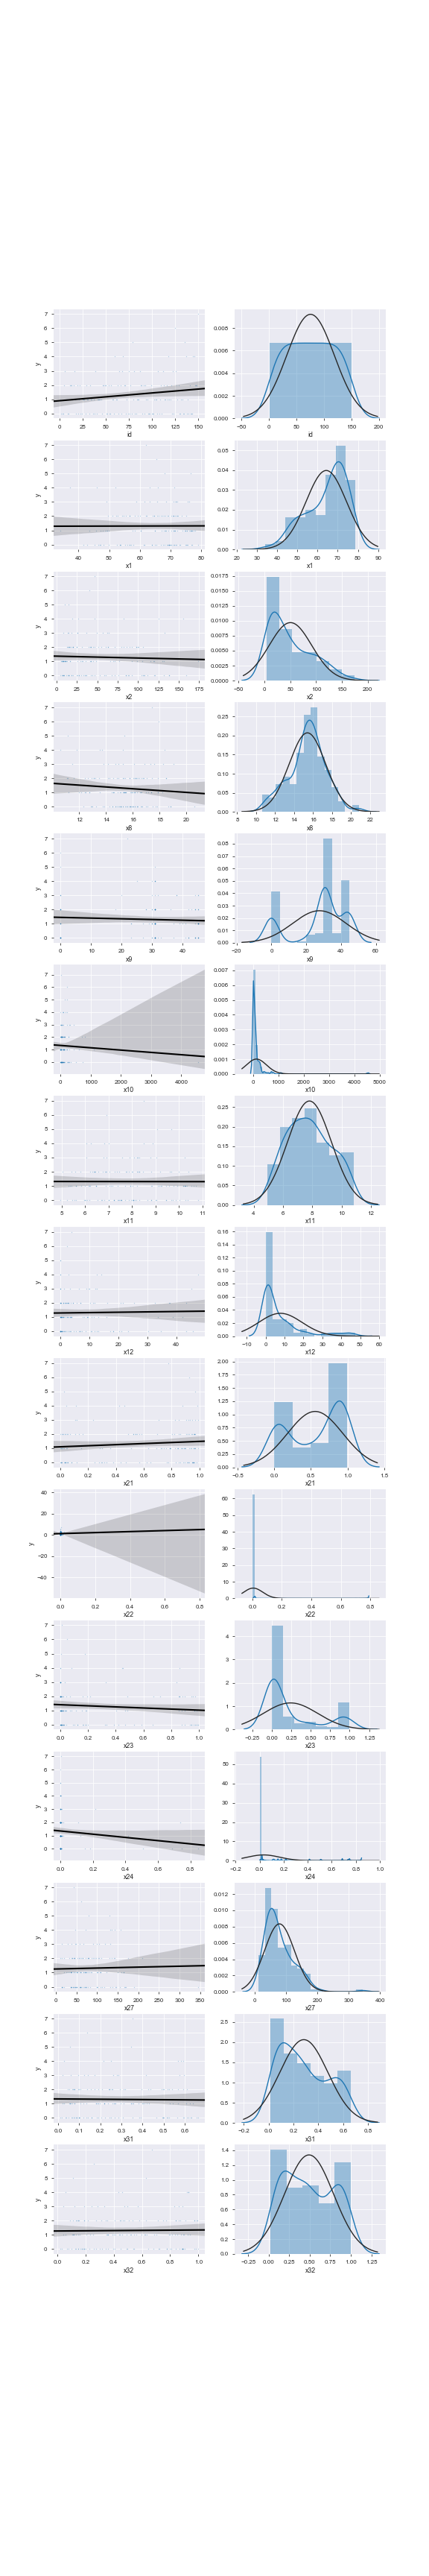

In [12]:
# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='yC', data=datos, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('y')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(datos[col].dropna() , fit=stats.norm)
    plt.xlabel(col)

<IPython.core.display.Javascript object>


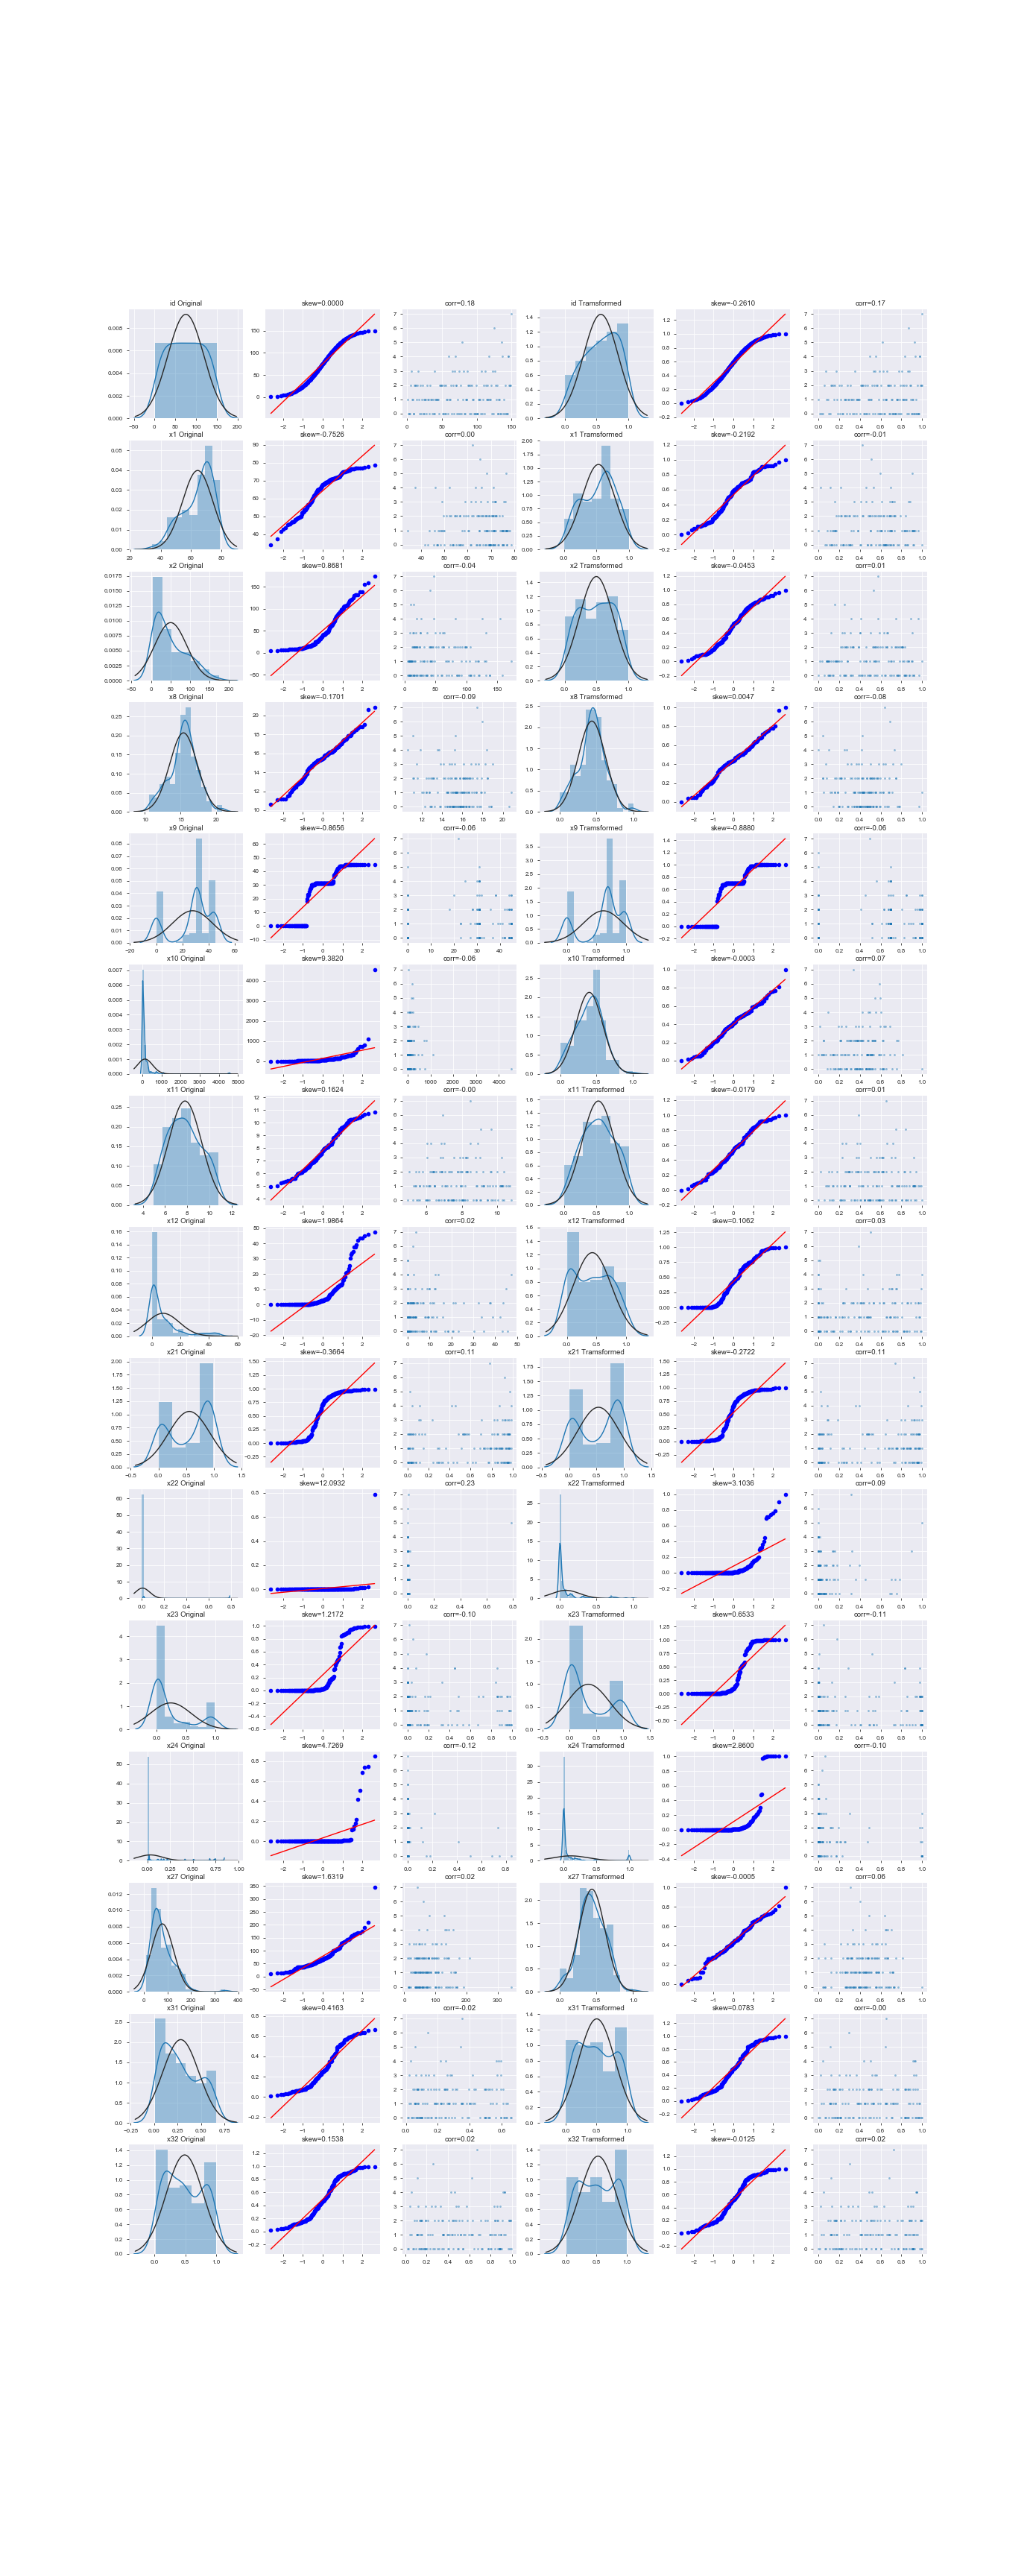

In [13]:
#Check effect of Box-Cox transforms on distributions of continuous variables
fcols = 6
frows = len(cols_continuous)
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_continuous:
    if var!='yC':
        dat = datos[[var, 'yC']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['yC'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['yC'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = minmax_scale(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['yC'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['yC'])[0][1]))

# Selección de Variables

In [4]:
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  }

In [10]:
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=10, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X,y)
print (gsearch1.scorer_ ) # print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   13.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   13.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   22.7s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   26.5s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   30.1s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   40.4s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   48.7s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   53.1s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  2.4min
[Parallel(

[18:10:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
make_scorer(mean_squared_error, greater_is_better=False)
best params
{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 10000, 'reg_alpha': 1e-05, 'reg_lambda': 0.45, 'subsample': 0.6}
best score
-1.5087435612226638


In [11]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
best_params={'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 10000, 'reg_alpha': 1e-05, 'reg_lambda': 0.45, 'subsample': 0.6}
params =gsearch1.best_params_ #best_params#

In [12]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

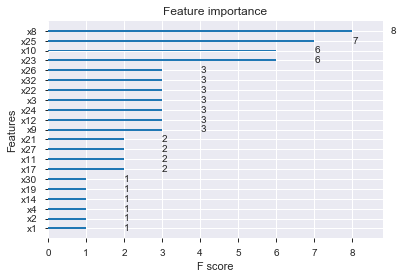

In [13]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [14]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [15]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         1.483530        0.039515        1.504006       0.060829
1         1.414839        0.048414        1.464006       0.066092
2         1.339857        0.037487        1.427388       0.077619
3         1.285126        0.029884        1.398687       0.082464
4         1.243127        0.022446        1.389719       0.079421

In [16]:
print((cv_results["test-rmse-mean"]).tail(5))

14    1.276537
15    1.279931
16    1.276349
17    1.272525
18    1.268840
Name: test-rmse-mean, dtype: float64


# Modelo

In [17]:
datos = pd.read_csv('datacountstudents.csv')
datos = datos.iloc[:,1:]
X2 = datos.drop(['yC'], axis=1)
y2 = datos['yC'].values

Divido los datos para entrenamiento y testeo

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size = 0.3, random_state=42)

Se estandarizan las cariables continuas y se crean data frame de las mismas

In [19]:
#nombres columnas continuas
train_C = X_train.select_dtypes(exclude=['int64'])
Columns_C = X_train.columns[(X_train.dtypes.values == np.dtype('float64'))]

# Estandarizar solo continuas en train
X_train_sc = X_train.copy()
col_names = Columns_C[0:13]
features_tr = X_train_sc[col_names]
scaler = StandardScaler().fit(features_tr.values)
features_tr = scaler.transform(features_tr.values)
X_train_sc[col_names] = features_tr

# Estandarizar solo continuas en test
X_test_sc = X_test.copy()
features_ts = X_test_sc[col_names]
features_ts = scaler.transform(features_ts.values)
X_test_sc[col_names] = features_ts

#dataframes
X_train_sc = pd.concat([X_train_sc], axis=1, sort=False)
X_test_sc = pd.concat([X_test_sc], axis=1, sort=False)
#X_train_sc.head()

Se construye el modelo con las variables escogidas

In [20]:
xg_reg = xgb.XGBRegressor(params=params,objective ='count:poisson')
columns=['x3','x1','x30','x25'] #columns=['x3','x1','x30','x23'] ['x8','x25','x32','x1'] ['x8','x25','x32','x30']
X_train_sc3=pd.DataFrame(X_train_sc,columns=columns)
X_test_sc3=pd.DataFrame(X_test_sc,columns=columns)

#Fit the model
xg_reg.fit(X_train_sc3,y_train)
#Make model predictions
preds = xg_reg.predict(X_test_sc3)
y_ts = pd.DataFrame(y_test,columns=['y_ts'])
pred= pd.DataFrame(np.round(preds),columns=['predict'])
#pred
columns=['y_ts','pred']
#dataframe y_test Vs Y_predict
Result1= pd.concat([y_ts,pred], axis=1, sort=False)
Result1['xg_reg_1']= [0]*len(Result1)
sum=0
for i in range(len(Result1)):
    if Result1.predict[i]<=0:
        if Result1.y_ts[i]<=0:
            Result1['xg_reg_1'][i]=1
            sum=sum+1
        else: Result1['xg_reg_1'] [i]=0
    elif Result1.predict[i]>0:
        if Result1.y_ts[i]>0:
            Result1['xg_reg_1'][i]=1
            sum=sum+1        
    else: Result1['xg_reg_1'] [i]=0
print("Explained_variance_score: ",explained_variance_score(y_test,pred))
print("Test 0 y >0: ",sum/len(Result1))
print("MSE_test:",np.sqrt(mean_squared_error(y_test, pred)))

Explained_variance_score:  -0.5138047138047137
Test 0 y >0:  0.7555555555555555
MSE_test: 1.4907119849998598


In [21]:
for i in range (0,4):
    v=vif(np.matrix(X_train_sc3[0:]),i)
    print("Variance inflation factor for {}: {}".format(X_train_sc3.columns[i],round(v,29)))

Variance inflation factor for x3: 1.3341260636076766
Variance inflation factor for x1: 1.6280679500976047
Variance inflation factor for x30: 6.933282655738174
Variance inflation factor for x25: 6.966646018583475


In [22]:
y_ts = pd.DataFrame(y_test,columns=['y_ts'])
pred= pd.DataFrame(np.round(preds),columns=['predict'])
#pred
columns=['y_ts','pred']# X_train_sc,label=y_train
Result = pd.concat([y_ts,pred], axis=1, sort=False)

<IPython.core.display.Javascript object>


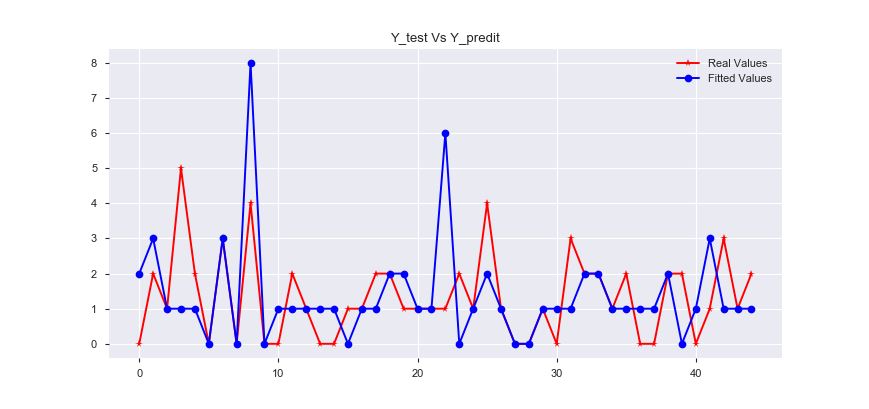

In [24]:
Result = pd.concat([y_ts,pred], axis=1, sort=False)
#Result
#preds = np.round(pred2.iloc[:,1])
%matplotlib notebook
plt.plot(range(len(y_ts)), y_ts, 'r*-', range(len(y_ts)), pred, 'bo-')
plt.title('Y_test Vs Y_predit')
plt.legend(['Real Values', 'Fitted Values'])
plt.show()

In [27]:
%matplotlib notebook
Result['Mayor0_test'] = (Result['predict']>0).astype(int)
Result['Mayor0_real'] = (Result['y_ts']>0).astype(int)
Result['prueba']= [0]*len(Result['Mayor0_real'])
sum=0
for i in range(len(Result['Mayor0_real'])):
    if Result.Mayor0_real[i]==Result.Mayor0_test[i]:
        Result['prueba'][i]=1
        sum=sum+1
    else: Result['prueba'] [i]=0
accu=sum/len(Result['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result['Mayor0_test'],Result['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

#sns.heatmap(confusion_matrix, annot=True)

Val 0 y >0:  0.7555555555555555
Predicted  0   1
Actual          
0          5   3
1          8  29


In [25]:
Result

y_ts  predict
0      0      2.0
1      2      3.0
2      1      1.0
3      5      1.0
4      2      1.0
5      0      0.0
6      3      3.0
7      0      0.0
8      4      8.0
9      0      0.0
10     0      1.0
11     2      1.0
12     1      1.0
13     0      1.0
14     0      1.0
15     1      0.0
16     1      1.0
17     2      1.0
18     2      2.0
19     1      2.0
20     1      1.0
21     1      1.0
22     1      6.0
23     2      0.0
24     1      1.0
25     4      2.0
26     1      1.0
27     0      0.0
28     0      0.0
29     1      1.0
30     0      1.0
31     3      1.0
32     2      2.0
33     2      2.0
34     1      1.0
35     2      1.0
36     0      1.0
37     0      1.0
38     2      2.0
39     2      0.0
40     0      1.0
41     1      3.0
42     3      1.0
43     1      1.0
44     2      1.0

Se prueba utilizando el modelo de regresion binomial negativa y regresión Poisson, pero los resultados son menores al contruido con XGboost

In [26]:
#Train Dataframe
#To erase index of X_train
X_train_sc2=X_train_sc.reset_index().values
#y_train as a dataframe
y_train2= pd.DataFrame(y_train,columns=['y_train'])
columns=['id','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19',
         'x20','x21','x22','x23','x24','x25','x26','x27','x28', 'x29', 'x30', 'x31','x32']
#change name of colums of X_train
X_train_sc2= pd.DataFrame(X_train_sc2,columns=columns)#
#drop id
X_train_sc2=X_train_sc2.drop(['id'], axis=1)
#Dataframe y with x's
X_train_sc2 = pd.concat([y_train2,X_train_sc2], axis=1, sort=False)

# Test DataFrame
X_test_sc2=X_test_sc.reset_index().values
y_test2= pd.DataFrame(y_test,columns=['y_test'])
X_test_sc2= pd.DataFrame(X_test_sc2,columns=columns)
X_test_sc2=X_test_sc2.drop(['id'], axis=1)
X_test_sc2 = pd.concat([y_test2,X_test_sc2], axis=1, sort=False)

In [30]:
m1 = glm('y_train2~x25+x30+x1+x3', data = X_train_sc2,family = sm.families.Poisson()).fit()
print (m1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               y_train2   No. Observations:                  105
Model:                            GLM   Df Residuals:                      100
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -143.68
Date:                Sat, 05 Oct 2019   Deviance:                       118.32
Time:                        20:27:40   Pearson chi2:                     97.3
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0200      0.610      4.949      0.000       1.824       4.216
x25           -0.4458      0.100     -4.472      0.0

In [35]:
ratio = m1.pearson_chi2 / m1.df_resid #underdispersion
print(ratio) 

0.9729339000264823


In [31]:
preds_2 = m1.predict(X_test_sc2)
preds_2=preds_2.reset_index().values
y_test2 = pd.DataFrame(y_test,columns=['y_ts'])
pred2= pd.DataFrame(preds_2,columns=['id','pred1'])
Result2 = pd.concat([y_test2,np.round(pred2.iloc[:,1])], axis=1, sort=False)
#Result2

In [32]:
%matplotlib notebook
Result2['Mayor0_test'] = (Result2['pred1']>0).astype(int)
Result2['Mayor0_real'] = (Result2['y_ts']>0).astype(int)
Result2['prueba']= [0]*len(Result2['Mayor0_real'])
sum=0
for i in range(len(Result2['Mayor0_real'])):
    if Result2.Mayor0_real[i]==Result2.Mayor0_test[i]:
        Result2['prueba'][i]=1
        sum=sum+1
    else: Result2['prueba'] [i]=0
accu=sum/len(Result2['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result2['Mayor0_test'],Result2['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result2, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

#sns.heatmap(confusion_matrix, annot=True)

Val 0 y >0:  0.7111111111111111
Predicted   0   1
Actual           
1          13  32


In [37]:
m_nb = glm('y_train2~x1+x30+x3+x25', data = X_train_sc2,family = sm.families.NegativeBinomial(alpha = 1)).fit()
print (m_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               y_train2   No. Observations:                  105
Model:                            GLM   Df Residuals:                      100
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -156.00
Date:                Sat, 05 Oct 2019   Deviance:                       66.076
Time:                        20:33:40   Pearson chi2:                     44.4
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7439      0.974      2.818      0.005       0.835       4.652
x1            -0.1357      0.170     -0.797      0.4

In [38]:
preds_3 = m_nb.predict(X_test_sc)
preds_3=preds_3.reset_index().values
pred3= pd.DataFrame(preds_3,columns=['id','pred1'])
y_test3 = pd.DataFrame(y_test,columns=['y_ts'])
Result3 = pd.concat([y_test3,np.round(pred3.iloc[:,1])], axis=1, sort=False)
Result3

y_ts  pred1
0      0    2.0
1      2    5.0
2      1    1.0
3      5    1.0
4      2    1.0
5      0    1.0
6      3    3.0
7      0    1.0
8      4    3.0
9      0    1.0
10     0    1.0
11     2    1.0
12     1    1.0
13     0    1.0
14     0    1.0
15     1    1.0
16     1    1.0
17     2    1.0
18     2    2.0
19     1    1.0
20     1    2.0
21     1    1.0
22     1    2.0
23     2    1.0
24     1    1.0
25     4    3.0
26     1    1.0
27     0    1.0
28     0    1.0
29     1    1.0
30     0    1.0
31     3    1.0
32     2    1.0
33     2    2.0
34     1    2.0
35     2    1.0
36     0    1.0
37     0    1.0
38     2    3.0
39     2    1.0
40     0    1.0
41     1    2.0
42     3    1.0
43     1    2.0
44     2    2.0

<IPython.core.display.Javascript object>


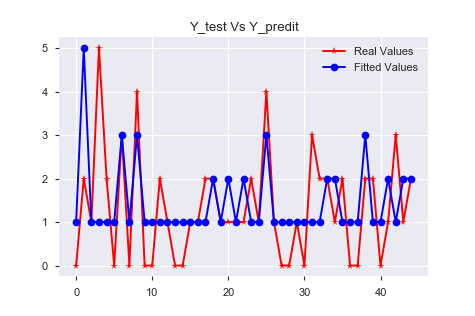

In [39]:
%matplotlib notebook
preds = np.round(pred2.iloc[:,1])
plt.plot(range(len(y_test3)), y_test3, 'r*-', range(len(y_test3)), preds, 'bo-')
plt.title('Y_test Vs Y_predit')
plt.legend(['Real Values', 'Fitted Values'])
plt.show()

In [40]:
%matplotlib notebook
Result3['Mayor0_test'] = (Result3['pred1']>0).astype(int)
Result3['Mayor0_real'] = (Result3['y_ts']>0).astype(int)
Result3['prueba']= [0]*len(Result3['Mayor0_real'])
sum=0
for i in range(len(Result3['Mayor0_real'])):
    if Result3.Mayor0_real[i]==Result3.Mayor0_test[i]:
        Result3['prueba'][i]=1
        sum=sum+1
    else: Result3['prueba'] [i]=0
accu=sum/len(Result3['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result3['Mayor0_test'],Result3['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result3, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

#sns.heatmap(confusion_matrix, annot=True)

Val 0 y >0:  0.7111111111111111
Predicted   0   1
Actual           
1          13  32
